In [1]:
import os

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from face_detector.data_visualization.images import (
    plot_examples,
    plot_face,
    plot_one_sample,
    plot_many_samples
)

from face_detector.data_validation.check_images import (
    my_root_listdir, 
    verify_images
)

from face_detector.data_image_generator.image_generator import DataGenerator

from face_detector.training_pipeline.images_train_test_split import images_train_test_split
from face_detector.data_processing.labels import get_face_center_coordinates

root_dir ='biwi_head_pose'

Using TensorFlow backend.


In [13]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [14]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.1.0
Default GPU Device: /device:GPU:0


In [6]:
root_listdir = my_root_listdir(root_dir)

Sum of images in directories:  0


In [3]:
verify_images(root_dir, root_listdir)

0 files caused error due to OSError and  ValueError.


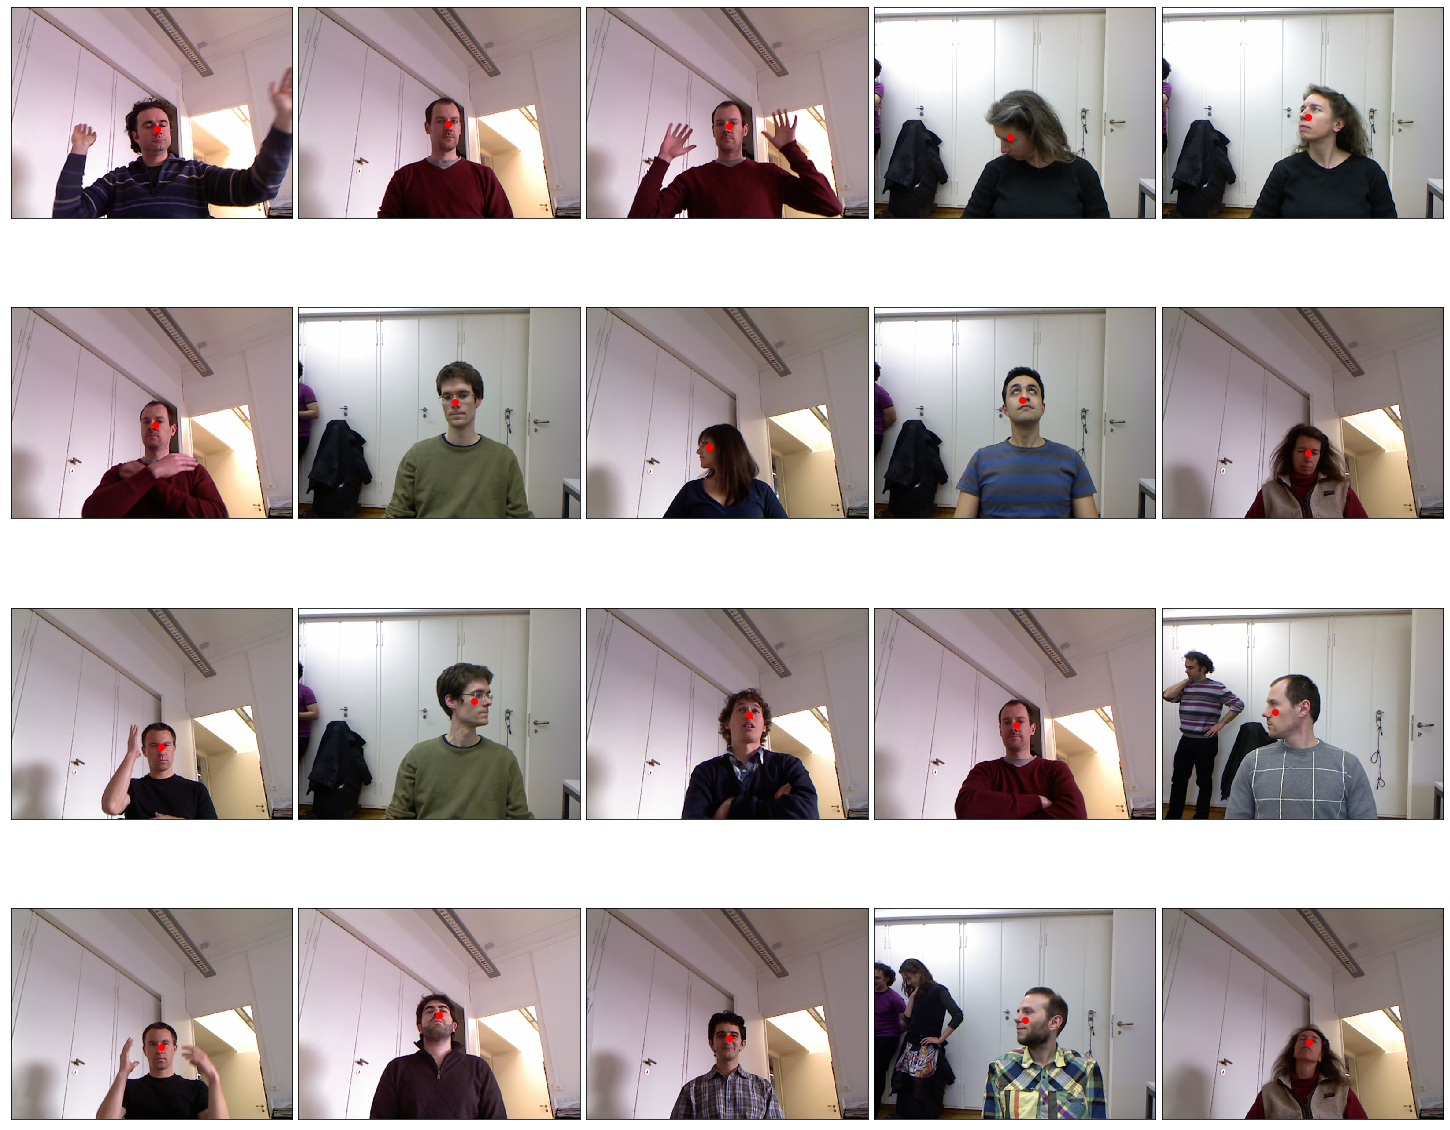

In [4]:
plot_examples(root_dir, root_listdir)

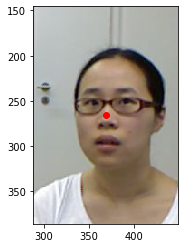

In [5]:
plot_face(root_dir)

In [6]:
test_set, valid_set, train_set = images_train_test_split(root_dir, 0.15, 0.15, 1)

Test set size:  1737.0
Valid set size:  2229.0
Train set size:  11688.0


In [4]:
EPOCHS = 10
BATCH_SIZE = 32
SCALE_SIZE = 1/4
IMG_HEIGHT, IMG_WIDTH = 480, 640

train_generator = DataGenerator(root_dir + '/train', 
                                   batch_size=BATCH_SIZE,
                                   target_size=(IMG_HEIGHT,IMG_WIDTH),
                                   scale_size=SCALE_SIZE,
                                   )

test_generator = DataGenerator(root_dir + '/test', 
                                   batch_size=BATCH_SIZE,
                                   target_size=(IMG_HEIGHT,IMG_WIDTH),
                                   scale_size=SCALE_SIZE,
                                   shuffle=False
                                   )

valid_generator = DataGenerator(root_dir + '/valid', 
                                   batch_size=BATCH_SIZE,
                                   target_size=(IMG_HEIGHT,IMG_WIDTH),
                                   scale_size=SCALE_SIZE,
                                   )

In [5]:
x, y = next(iter(train_generator))

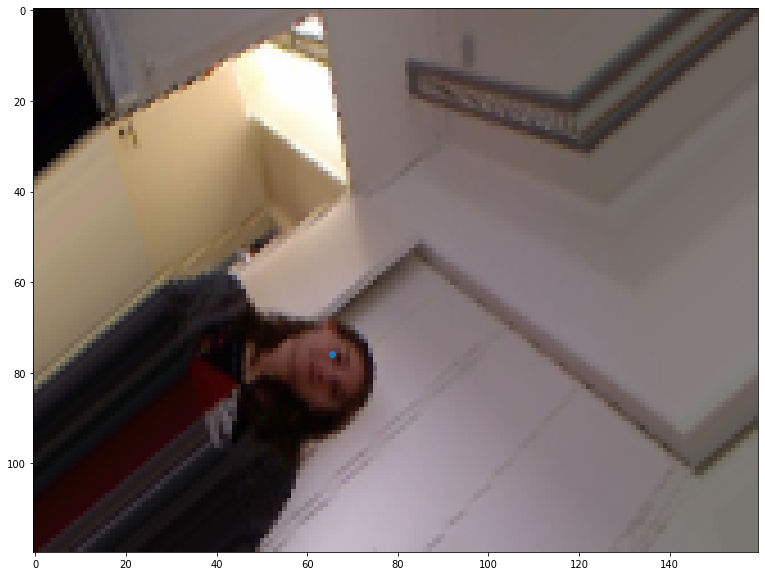

In [6]:
plot_one_sample(x[20], y[20])

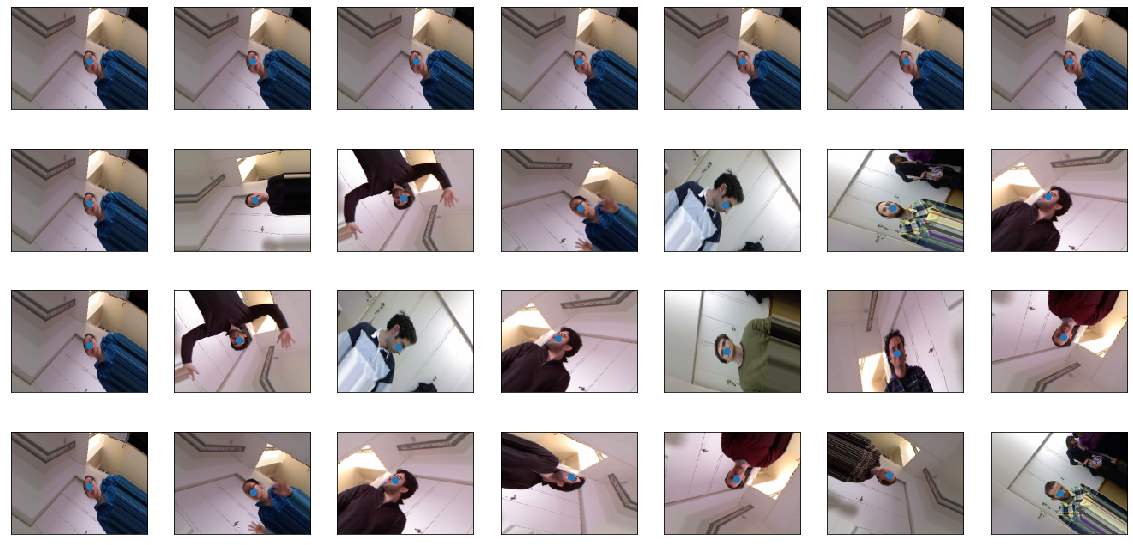

In [7]:
plot_many_samples(train_generator)

In [8]:
import os

from keras.layers import (
    Dense,
    Activation,
    Conv2D,
    MaxPool2D,
    Flatten,
    BatchNormalization,
    Dropout,
)
from keras import optimizers
from keras import backend as K
from keras.layers.core import Dense, Flatten
from keras import applications
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Input, Model, load_model
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU

In [9]:
K.clear_session()

image_input = Input(shape=(int(IMG_HEIGHT*SCALE_SIZE), int(IMG_WIDTH*SCALE_SIZE),3))
base_model = applications.ResNet50(weights='imagenet',include_top= False, input_tensor=image_input)
for layer in base_model.layers:
    layer.trainable = False

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dense(2))

model = Model(inputs = base_model.input, outputs= top_model(base_model.output))

model.summary()

model.compile(loss = 'mse',
            optimizer = 'adam',
            metrics = ['mae', 'mse'])

C:\Users\Milosz\.conda\envs\gputest\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 80, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [38]:
models_dir = os.getcwd() + '/models'
epochs_to_wait_for_improve = 3

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=epochs_to_wait_for_improve)

In [10]:
checkpoint_callback = ModelCheckpoint(models_dir + '/model.h5',
                                      monitor='val_loss', 
                                      verbose=1, 
                                      save_best_only=True,
                                      mode='min', 
                                      save_weights_only=False)
                                      
if 'model.h5' in os.listdir(models_dir):
    model = load_model(models_dir + '/model.h5')
else:
    history = model.fit_generator(
        train_generator,
        epochs=EPOCHS,
        steps_per_epoch = train_generator.__len__(),
        validation_data=valid_generator,
        validation_steps=valid_generator.__len__(), 
        callbacks=[early_stopping_callback, checkpoint_callback],
        shuffle = True)
    
    #model.save(models_dir + '/model.h5')
  

Epoch 1/10
365/365 [==============================] - 1241s 3s/step - loss: 108.4548 - mae: 7.2879 - mse: 108.4548 - val_loss: 424.2826 - val_mae: 17.9098 - val_mse: 412.6904

Epoch 00001: val_loss improved from inf to 424.28259, saving model to C:\Users\Milosz\Downloads\Programowanie\Python\Data Science\ML-projekty\Solvro\Face detector/models/model.h5
Epoch 2/10
365/365 [==============================] - 1119s 3s/step - loss: 43.7368 - mae: 5.2100 - mse: 43.7368 - val_loss: 196.7024 - val_mae: 10.8500 - val_mse: 176.0284

Epoch 00002: val_loss improved from 424.28259 to 196.70242, saving model to C:\Users\Milosz\Downloads\Programowanie\Python\Data Science\ML-projekty\Solvro\Face detector/models/model.h5
Epoch 3/10
365/365 [==============================] - 1112s 3s/step - loss: 40.4126 - mae: 4.9913 - mse: 40.4126 - val_loss: 148.4730 - val_mae: 11.1334 - val_mse: 178.8351

Epoch 00003: val_loss improved from 196.70242 to 148.47299, saving model to C:\Users\Milosz\Downloads\Programowa

In [19]:
for layer in model.layers:
    layer.trainable = False

learning_rate = 0.001
opt = optimizers.Adam(lr = learning_rate)

checkpoint_callback_2 = ModelCheckpoint(models_dir + '/model_2.h5',
                                      monitor='val_loss', 
                                      verbose=1, 
                                      save_best_only=True,
                                      mode='min', 
                                      save_weights_only=False)

if 'model_2.h5' in os.listdir(models_dir):
    model = load_model(models_dir + '/model_2.h5')
else:
    history = model.fit_generator(
        train_generator,
        epochs=EPOCHS,
        steps_per_epoch = train_generator.__len__(),
        validation_data=valid_generator,
        validation_steps=valid_generator.__len__(), 
        callbacks=[early_stopping_callback, checkpoint_callback_2],
        shuffle = True)
    
    #model.save(models_dir + '/model_2.h5')
  

Epoch 1/10
365/365 [==============================] - 1340s 4s/step - loss: 9.1820 - mae: 2.3607 - val_loss: 248.2047 - val_mae: 14.5653

Epoch 00001: val_loss improved from inf to 248.20474, saving model to C:\Users\Milosz\Downloads\Programowanie\Python\Data Science\ML-projekty\Solvro\Face detector/models/model_2.h5
Epoch 2/10
365/365 [==============================] - 1296s 4s/step - loss: 9.1542 - mae: 2.3659 - val_loss: 221.0568 - val_mae: 14.4794

Epoch 00002: val_loss improved from 248.20474 to 221.05679, saving model to C:\Users\Milosz\Downloads\Programowanie\Python\Data Science\ML-projekty\Solvro\Face detector/models/model_2.h5
Epoch 3/10
365/365 [==============================] - 1378s 4s/step - loss: 9.0958 - mae: 2.3530 - val_loss: 270.2314 - val_mae: 14.5934

Epoch 00003: val_loss did not improve from 221.05679
Epoch 4/10
365/365 [==============================] - 1314s 4s/step - loss: 9.1326 - mae: 2.3626 - val_loss: 221.0675 - val_mae: 14.6142

Epoch 00004: val_loss did n

In [20]:
learning_rate = 0.001
opt = optimizers.Adam(lr = learning_rate)

for layer in model.layers:
    layer.trainable = True

checkpoint_callback_3 = ModelCheckpoint(models_dir + '/model_3.h5',
                                      monitor='val_loss', 
                                      verbose=1, 
                                      save_best_only=True,
                                      mode='min', 
                                      save_weights_only=False)

if 'model_3.h5' in os.listdir(models_dir):
    model = load_model(models_dir + '/model_3.h5')
else:
    history = model.fit_generator(
        train_generator,
        epochs=EPOCHS,
        steps_per_epoch = train_generator.__len__(),
        validation_data=valid_generator,
        validation_steps=valid_generator.__len__(), 
        callbacks=[early_stopping_callback, checkpoint_callback_3],
        shuffle = True)
    
    #model.save(models_dir + '/model_2.h5')
  

Epoch 1/10
365/365 [==============================] - 25983s 71s/step - loss: 30.3571 - mae: 3.0332 - val_loss: 21.7949 - val_mae: 4.0188

Epoch 00001: val_loss improved from inf to 21.79489, saving model to C:\Users\Milosz\Downloads\Programowanie\Python\Data Science\ML-projekty\Solvro\Face detector/models/model_3.h5
Epoch 2/10
365/365 [==============================] - 2630s 7s/step - loss: 3.4511 - mae: 1.4544 - val_loss: 9.2753 - val_mae: 2.4142

Epoch 00002: val_loss improved from 21.79489 to 9.27533, saving model to C:\Users\Milosz\Downloads\Programowanie\Python\Data Science\ML-projekty\Solvro\Face detector/models/model_3.h5
Epoch 3/10
365/365 [==============================] - 1588s 4s/step - loss: 3.0438 - mae: 1.3664 - val_loss: 2.3295 - val_mae: 1.5148

Epoch 00003: val_loss improved from 9.27533 to 2.32953, saving model to C:\Users\Milosz\Downloads\Programowanie\Python\Data Science\ML-projekty\Solvro\Face detector/models/model_3.h5
Epoch 4/10
365/365 [========================

In [21]:
learning_rate = 0.0005
opt = optimizers.Adam(lr = learning_rate)

checkpoint_callback_4 = ModelCheckpoint(models_dir + '/model_4.h5',
                                      monitor='val_loss', 
                                      verbose=1, 
                                      save_best_only=True,
                                      mode='min', 
                                      save_weights_only=False)

if 'model_4.h5' in os.listdir(models_dir):
    model = load_model(models_dir + '/model_4.h5')
else:
    history = model.fit_generator(
        train_generator,
        epochs=5,
        steps_per_epoch = train_generator.__len__(),
        validation_data=valid_generator,
        validation_steps=valid_generator.__len__(), 
        callbacks=[early_stopping_callback, checkpoint_callback_4],
        shuffle = True)
    

Epoch 1/5
365/365 [==============================] - 1293s 4s/step - loss: 2.0364 - mae: 1.1155 - val_loss: 2.8215 - val_mae: 1.3360

Epoch 00001: val_loss improved from inf to 2.82148, saving model to C:\Users\Milosz\Downloads\Programowanie\Python\Data Science\ML-projekty\Solvro\Face detector/models/model_4.h5
Epoch 2/5
365/365 [==============================] - 4835s 13s/step - loss: 1.7870 - mae: 1.0509 - val_loss: 4.1638 - val_mae: 1.4128

Epoch 00002: val_loss did not improve from 2.82148
Epoch 3/5
365/365 [==============================] - 1272s 3s/step - loss: 1.5052 - mae: 0.9638 - val_loss: 11.5450 - val_mae: 1.9681

Epoch 00003: val_loss did not improve from 2.82148
Epoch 4/5
365/365 [==============================] - 1297s 4s/step - loss: 2.2859 - mae: 1.1905 - val_loss: 4.7231 - val_mae: 1.6309

Epoch 00004: val_loss did not improve from 2.82148


In [22]:
mae = model.evaluate_generator(test_generator)

In [23]:
metrics = pd.DataFrame([mae], columns = model.metrics_names)
metrics.style.hide_index()

loss,mae
4.377246,2.036525


In [24]:
mae_val = model.evaluate_generator(valid_generator)

In [25]:
metrics_val = pd.DataFrame([mae_val], columns = model.metrics_names)
metrics_val.style.hide_index()

loss,mae
4.611513,1.636656


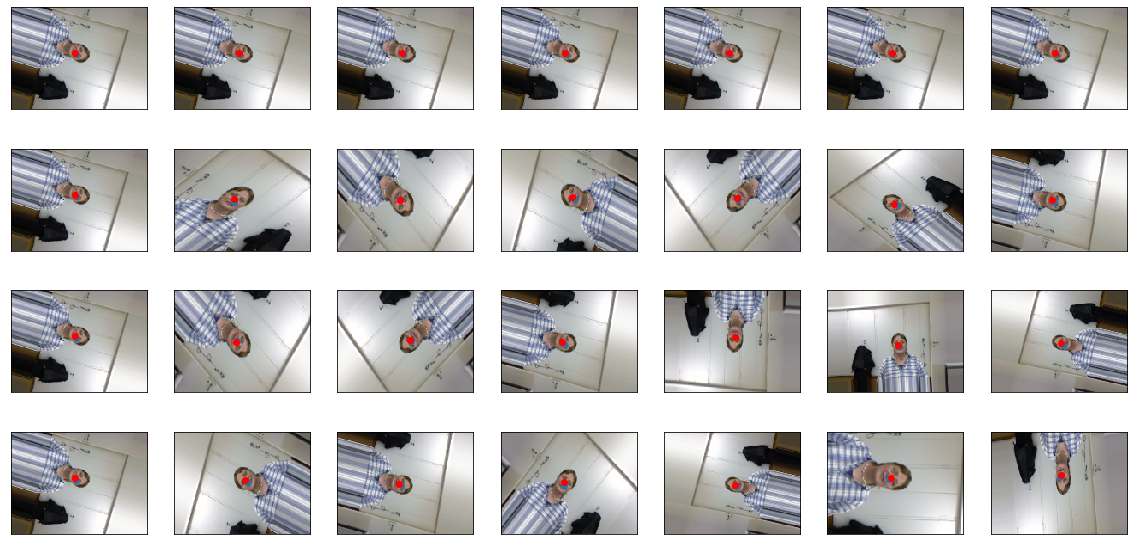

In [26]:
plot_many_samples(test_generator, model=model)

## Camera

In [34]:
import cv2
import numpy as np

def split_video_channels(mirror=False):
    fig = plt.figure()

    cap = cv2.VideoCapture(0)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    scaled_width = int(IMG_WIDTH * SCALE_SIZE)
    scaled_height = int(IMG_HEIGHT * SCALE_SIZE)

    cv2.namedWindow('Camera',cv2.WINDOW_NORMAL)
    
   
    out = cv2.VideoWriter('output.avi',fourcc, 20.0, (scaled_width, scaled_height))
    
    zeros = None

    while True:
        ret_val, frame = cap.read()
        frame = cv2.resize(frame, (scaled_width, scaled_height))
        if ret_val == True:
            if mirror:
                #flip the image
                frame = cv2.flip(frame, 1)
            

            out.write(frame)
            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            cords = tuple([int(i) for i in model.predict(np.expand_dims(frame_rgb, axis=0)).ravel()])
            cv2.circle(frame, cords, radius=1, color=(0, 0, 255), thickness=-1) 


            cv2.imshow('Camera', frame)

            #plt.imshow(frame)
        else:
            break
 
        if cv2.waitKey(1) & 0xFF == ord('q'):  # if 'q' is pressed then quit
            break
        print(tuple(model.predict(np.expand_dims(frame, axis=0)).ravel()))
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    return  frame, frame_rgb


In [35]:
frame, frame_rgb = split_video_channels()

(80.4751, 65.17355)
(80.52947, 65.10848)
(80.55139, 65.10968)
(80.45769, 65.19464)
(80.40107, 65.188385)
(80.28886, 65.22682)
(80.12, 65.34473)
(79.85067, 65.34244)
(79.72725, 65.5434)
(79.44822, 65.35787)
(79.33474, 65.29271)
(79.33195, 65.4469)
(79.45791, 65.35917)
(79.400795, 65.5786)
(79.52382, 65.80016)
(80.04183, 66.22861)
(79.578705, 65.5901)
(80.24059, 64.86545)
(80.14738, 65.51399)
(80.50425, 65.48895)
(80.35946, 64.9437)
(80.47061, 64.9223)
(80.15142, 65.322754)
(80.21043, 65.221146)
(80.01023, 65.35433)
(80.16109, 65.17734)
(80.28385, 65.074646)
(80.49768, 64.88276)
(80.60112, 65.00221)
(80.61941, 65.03352)
(80.09438, 65.28532)
(79.79662, 65.394554)
(80.14068, 64.32926)
(80.00186, 64.626595)
(79.71038, 64.559814)
(78.99142, 63.86549)
(78.23493, 63.68326)
(77.70643, 64.08407)
(76.67466, 64.65076)
(76.097824, 64.89618)
(75.622826, 64.52062)
(75.01036, 63.99332)
(75.472786, 63.53513)
(75.48652, 63.57746)
(75.33293, 64.10976)
(75.67003, 63.8809)
(76.217766, 63.17465)
(76.42382, 

<Figure size 432x288 with 0 Axes>

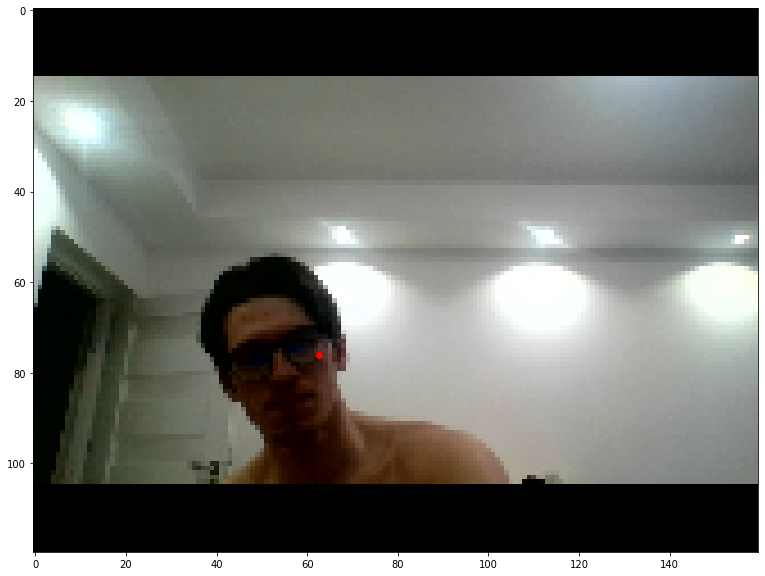

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(frame_rgb)
plt.scatter(*model.predict(np.expand_dims(frame, axis=0)).ravel()[::-1],c="red")